# Text Classification

In [5]:
from datasets import list_datasets
from datasets import load_dataset

In [2]:
all_datasets = list_datasets()

In [3]:
len(all_datasets)

4150

In [4]:
all_datasets[:10]

['acronym_identification',
 'ade_corpus_v2',
 'adversarial_qa',
 'aeslc',
 'afrikaans_ner_corpus',
 'ag_news',
 'ai2_arc',
 'air_dialogue',
 'ajgt_twitter_ar',
 'allegro_reviews']

In [6]:
# loading emotions dataset
emotions = load_dataset('emotion')

Using custom data configuration default


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to C:\Users\dmber\.cache\huggingface\datasets\emotion\default\0.0.0\348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [8]:
train_ds = emotions['train']

In [9]:
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [10]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [12]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [13]:
train_ds[:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

In [14]:
import pandas as pd

In [15]:
emotions.set_format(type='pandas')

In [16]:
df = emotions['train'][:]

In [17]:
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [23]:
def label_int2str(row):
    return emotions['train'].features['label'].int2str(row)

In [24]:
df['label_name'] = df['label'].apply(label_int2str)

In [25]:
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### Looking at class distributions
Whenever you are working on text classification problems, it is a good idea to examine the distribution of examples across the classes. A dataset with a skewed class distribution might require different treatment in terms of the training loss and evaluation metrics than a balances one. 

In [26]:
import matplotlib.pyplot as plt

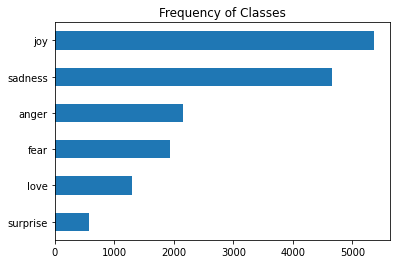

In [32]:
df['label_name'].value_counts(ascending=True).plot.barh()
plt.title('Frequency of Classes')
plt.show()

There are several ways to deal with imbalanced data, including:
* Randomly oversampling the minority class
* Randomly undersampling the majority class
* Gather more labeled data from the underrepressented classes.

### How Long Are Our Tweets?
Transformer models have a maximum input sequence length that is referred to as the maximum context size. For applications using DistilBERT, the maximum context size is 512 tokens, which amounts to a few paragraphs of text. 

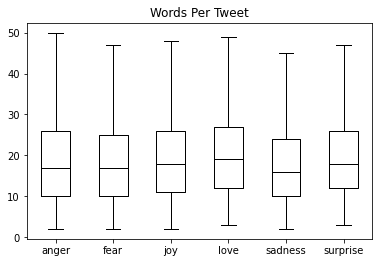

In [38]:
df['Words Per Tweet'] = df['text'].str.split().apply(len)
df.boxplot('Words Per Tweet', by='label_name', grid=False, showfliers=False, color='black')
plt.suptitle('')
plt.xlabel('')
plt.show()

In [39]:
emotions.reset_format()

### Character Tokenization
The simplest tokenization scheme is to feed each character individually to the model. In Python, str objects are really arrays under the hood, which allows us to quickly implement character-level tokenization with just one line of code.

In [43]:
text = 'Tokenizing text is a core task of NLP.'
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


In [44]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}

In [45]:
token2idx

{' ': 0,
 '.': 1,
 'L': 2,
 'N': 3,
 'P': 4,
 'T': 5,
 'a': 6,
 'c': 7,
 'e': 8,
 'f': 9,
 'g': 10,
 'i': 11,
 'k': 12,
 'n': 13,
 'o': 14,
 'r': 15,
 's': 16,
 't': 17,
 'x': 18,
 'z': 19}

In [47]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [48]:
categorical_df = pd.DataFrame(
    {'Name': ['Bumblebee', 'Optimus Prime', 'Megatron'],
     'Label ID': [0, 1, 2]}
)
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


The problem with this approach is that it creates a fictittious ordering between the name, and neural networks are really good at learning these kind of relationships. So instead, we can create a new column for each category and assign a 1 where the category is true, and 0 otherwise. 

In [49]:
pd.get_dummies(categorical_df['Name'])

,Bumblebee,Megatron,Optimus Prime
0,1,0,0
1,0,0,1
2,0,1,0


The rows of this DataFrame are the one-hot vectors, which have a single 'hot' entry with a 1 and 0s everywhere else. Now, looking at our input_ids, we have a similar problem: the elements create an ordinal scale. This means that adding or subtracting two IDs is a meaningless operation, since the result is a new ID that represents another random token. 

On the other hand, the result of adding two one-hot encodings can easily be iterpreted: the two entries that are 'hot' indicate that the corresponding tokens co-occur. We can create the one-hot encoding in PyTorch by converting input_ids to a tensor and applying one_hot() function.

In [50]:
import torch
import torch.nn.functional as F

In [51]:
input_ids = torch.tensor(input_ids)
input_ids.shape

torch.Size([38])

In [52]:
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))

In [54]:
one_hot_encodings, one_hot_encodings.shape

(tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
      

### Word Tokenization
Instead of splitting the text into characters, we can split it into words and map each word to an integer. Using words from the outset enables the model to skip the step of learning words from characters, and thereby reducing the complexity of the training process.

One simple class of word tokenizers uses whitespace to tokenize the text. We can do this by applying pythons split() function directly on the raw text

In [56]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


### Subword Tokenization
The basic idea behind subword tokenization is to combine the best aspects of character and word tokenization. On the one hand, we want to split rare words into smaller units to allow the model to deal with complex words and mispellings. On the other hand, we want to keep frequent words as unique entities so that we can keep the length of our inputs to a manageable size. The main distinguishing feature of subword tokenization (as well as word tokenization) is that it is learned from the pretraining corpus using a mix of statistical rules and algorithms. 

There are several subword tokenization algorithms that are commonly used in NLP but lets start with WordPiece, which is used by the BERT and DistilBERT tokenizers. 

In [57]:
from transformers import AutoTokenizer

In [58]:
model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

The AutoTokenizer class belongs to a larger set of 'auto' classes whose job is to automatically retrieve the model's configuration, pretrained weights, or vocabularly from the name of the checkpoint. This allows you to quickly switch between models, but if you wish to load the specific class manually you can do so as well.

In [59]:
from transformers import DistilBertTokenizer

In [60]:
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [61]:
encoded_text = tokenizer(text)
encoded_text

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [62]:
# converting back to tokens
tokens = tokenizer.convert_ids_to_tokens(encoded_text['input_ids'])

In [64]:
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [65]:
# converting the tokens back to string
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [66]:
tokenizer.vocab_size, tokenizer.model_max_length, tokenizer.model_input_names

(30522, 512, ['input_ids', 'attention_mask'])

### Tokenizing the Whole Dataset

In [68]:
def tokenize(batch):
    """
    This function applies the tokenizer to a batch of examples. Padding=True will pad the examples with zero to the size of the longest one in a batch, and truncation=True will truncate the examples to the model's maximum context size.
    """
    return tokenizer(batch['text'], padding=True, truncation=True)

In [72]:
tokenize(emotions['train'][:3])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102], [101, 10047, 9775, 1037, 3371, 2000, 2695, 1045, 2514, 20505, 3308, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}

In [75]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [76]:
type(emotions)

datasets.dataset_dict.DatasetDict

In [78]:
emotions_encoded['train']

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 16000
})

By default, the map() method operates individually on every example in the corpus, so setting batched=True will encode the tweets in batches. Because we've set batch_size=None, our tokenize() function will be applied on the full dataset as a single batch. This ensures that input tesnors and attention masks have the same shape globally, and we can see that this operation has added new input_ids and attention_masks to the dataset

In [79]:
emotions['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

We have two options to train such a model on our Twitter Dataset:

**Feature Extraction**: We use the hidden states as features and just train a classifier on them, without modifying the pretrained model. 

**Fine-Tuning**: We train the whole model end-to-end, which also updates the parameters of the pretrained model. 